### Advanced Machine Learning

# Home Exercise #2

Assignment Due: 18/04/21 23:59

Jonathan Schler

In [2]:
student1Name="Alexander Kruglyak" # student1 name here
student1ID="323637736" # student1 ID here


student2Name="Sofya Zubtsovsky" # student2 name here
student2ID="337839112" # student2 ID here


The goal of this homework is to provide a realistic setting for a machine learning task. Therefore instructions will not specify the exact steps to carry out. Instead, it is part of theassignment to identify promising features, models and preprocessing methods and apply themas appropriate.

The overall goal is to predict whether a specific credit card transaction is fraudulent or not. Please use the data from this dataset provided on Kaggle here:https://www.kaggle.com/kartik2112/fraud-detection. The Kaggle page also contains a description of the dataset. You will use the train set for training the model and test set for validation.

You are free to manipulate the train dataset as you think is appropriate. You do not have to use the wholedataset, you can subsample if you want. While the modelling process is likely iterative, please lay out the  following tasks in the given order to facilitate grading.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [16]:
COLUMNS_TO_DROP = [
#     "Unnamed: 0",
#     "trans_num",
#     "trans_date_trans_time", # TODO: we need to split it to bins of day
    
#     "first", "last", # TODO: we can think to identify nationality by name
] 

def get_continuous_features(df):
    return df.select_dtypes(exclude=['object'])

def get_categorical_features(df):
    return df.select_dtypes(include=['object'])

def read_test_data():
    return drop_columns(read_data("fraudTest.csv"), COLUMNS_TO_DROP)

def read_data(file_name):
    return pd.read_csv(file_name)

def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1,errors='ignore')

In [17]:
features_description = {
'transdatetrans_time' : 'Transaction DateTime',
'cc_num' : 'Credit Card Number of Customer',
'merchant' : 'Merchant Name',
'category' : 'Category of Merchant',
'amt' : 'Amount of Transaction',
'first' : 'First Name of Credit Card Holder',
'last' : 'Last Name of Credit Card Holder',
'gender' : 'Gender of Credit Card Holder',
'street' : 'Street Address of Credit Card Holder',
'city' : 'City of Credit Card Holder',
'state' : 'State of Credit Card Holder',
'zip' : 'Zip of Credit Card Holder',
'lat' : 'Latitude Location of Credit Card Holder',
'long' : 'Longitude Location of Credit Card Holder',
'city_pop' : 'Credit Card Holder City Population',
'job' : 'Job of Credit Card Holder',
'dob' :'Date of Birth of Credit Card Holder',
'trans_num' : 'Transaction Number',
'unix_time' : 'UNIX Time of transaction',
'merch_lat' : 'Latitude Location of Merchant',
'merch_long' : 'Longitude Location of Merchant',
'is_fraud' : 'Fraud Flag'
}

title_font = {
        'color':  'darkblue',
        'weight': 'normal',
        'size': 20,
        }
labels_font = {
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [18]:
#### trans_date_trans_time to trans_date_category ####

def get_hour_as_category(hour):
        day_time_category = "night"
        
        if 6 <= hour and hour < 12: 
            day_time_category = "morning"
        elif hour >=12 and hour < 18:
            day_time_category = "afternoon"
        elif hour >= 18 and hour < 22:
            day_time_category = "evening"
            
        return day_time_category

def convert_to_categorical_trans_date(df):
    _df = df.copy()
    trans_date_category_list = []
    
    for  i, d in enumerate(get_categorical_features(_df).trans_date_trans_time):
        day_of_week = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').strftime('%A');
        hour = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').hour
        trans_date_category = "{}_{}".format(day_of_week, hour)
        trans_date_category_list.append(trans_date_category)
    
    _df['trans_date_category'] = trans_date_category_list
    return _df

def convert_to_categorical_trans_date_and_drop(df):
    converted_df = convert_to_categorical_trans_date(df)
    return drop_columns(converted_df, ["trans_date_trans_time"])

In [19]:
#### city_pop to city_pop_category ####

def population_as_category(p):
    category = "2M+"
    
    if p <= 100:
        category = "100-"
    elif p <= 500:
        category = "500-"
    elif p <= 1000:
        category = "1K-"
    elif p <= 2000:
        category = "2K-"
    elif p <= 3000:
        category = "3K-"
    elif p <= 5000:
        category = "5K-"
    elif p <= 10000:
        category = "10K-"
    elif p <= 30000:
        category = "30K-"
    elif p <= 50000:
        category = "50K-"
    elif p <= 100000:
        category = "100K-"
    elif p <= 200000:
        category = "200K-"
    elif p <= 500000:
        category = "500K-"
    elif p <= 1000000:
        category = "1M-"
    elif p <= 1500000:
        category = "1.5M-"
    elif p <= 2000000:
        category = "2M-"
        
    return category

def convert_to_categorical_city_pop(df):
    _df = df.copy()
    city_pop_category_list = []
    
    for p in df.city_pop:
        category = population_as_category(p)
        city_pop_category_list.append(category)
        
    _df['city_pop_category'] = city_pop_category_list
    return _df

In [20]:
def convert_cc_to_cc_type_and_drop(df):
    _df = convert_cc_to_cc_type(df)
    return drop_columns(_df, ["cc_num"])

def convert_cc_to_cc_type(df):
    _df = df.copy()
    cc_category_list = []
    
    for cc in df.cc_num:
        cc_category_list.append(get_cc_type(cc))
        
    _df['cc_type'] = cc_category_list
    return _df

def get_cc_type(cc_number):
    cc_number = str(cc_number)
    if is_american_express(cc_number): return 'AMEX'
    if is_visa(cc_number): return 'VISA'
    if is_mastercard(cc_number): return 'MasterCard'
    if is_discover(cc_number): return 'Discover'
    if is_jcb(cc_number): return 'JCB'
    if is_diners_club(cc_number): return 'DinersClub'
    if is_laser(cc_number): return 'Laser'
    if is_maestro(cc_number): return 'Maestro'
    if is_visa_electron(cc_number): return 'VisaElectron'
    if is_total_rewards_visa(cc_number): return 'TotalRewardsVisa'
    if is_diners_club_carte_blanche(cc_number): return 'DinersClubCarteBlanche'
    if is_diners_club_carte_international(cc_number): return 'DinersClubCarteInt'
    
    return 'unknown'

def is_american_express(cc_number):
    """Checks if the card is an american express. If us billing address country code, & is_amex, use vpos
    https://en.wikipedia.org/wiki/Bank_card_number#cite_note-GenCardFeatures-3
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^3[47][0-9]{13}$', cc_number))


def is_visa(cc_number):
    """Checks if the card is a visa, begins with 4 and 12 or 15 additional digits.
    :param cc_number: unicode card number
    """

    # Standard Visa is 13 or 16, debit can be 19
    if bool(re.match(r'^4', cc_number)) and len(cc_number) in [13, 16, 19]:
        return True

    return False


def is_mastercard(cc_number):
    """Checks if the card is a mastercard. Begins with 51-55 or 2221-2720 and 16 in length.
    :param cc_number: unicode card number
    """
    if len(cc_number) == 16 and cc_number.isdigit():  # Check digit, before cast to int
        return bool(re.match(r'^5[1-5]', cc_number)) or int(cc_number[:4]) in range(2221, 2721)
    return False


def is_discover(cc_number):
    """Checks if the card is discover, re would be too hard to maintain. Not a supported card.
    :param cc_number: unicode card number
    """
    if len(cc_number) == 16:
        try:
            # return bool(cc_number[:4] == '6011' or cc_number[:2] == '65' or cc_number[:6] in range(622126, 622926))
            return bool(cc_number[:4] == '6011' or cc_number[:2] == '65' or 622126 <= int(cc_number[:6]) <= 622925)
        except ValueError:
            return False
    return False


def is_jcb(cc_number):
    """Checks if the card is a jcb. Not a supported card.
    :param cc_number: unicode card number
    """
    # return bool(re.match(r'^(?:2131|1800|35\d{3})\d{11}$', cc_number))  # wikipedia
    return bool(re.match(r'^35(2[89]|[3-8][0-9])[0-9]{12}$', cc_number))  # PawelDecowski


def is_diners_club(cc_number):
    """Checks if the card is a diners club. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^3(?:0[0-6]|[68][0-9])[0-9]{11}$', cc_number))  # 0-5 = carte blance, 6 = international


def is_laser(cc_number):
    """Checks if the card is laser. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^(6304|670[69]|6771)', cc_number))


def is_maestro(cc_number):
    """Checks if the card is maestro. Not a supported card.
    :param cc_number: unicode card number
    """
    possible_lengths = [12, 13, 14, 15, 16, 17, 18, 19]
    return bool(re.match(r'^(50|5[6-9]|6[0-9])', cc_number)) and len(cc_number) in possible_lengths


# Child cards

def is_visa_electron(cc_number):
    """Child of visa. Checks if the card is a visa electron. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^(4026|417500|4508|4844|491(3|7))', cc_number)) and len(cc_number) == 16


def is_total_rewards_visa(cc_number):
    """Child of visa. Checks if the card is a Total Rewards Visa. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^41277777[0-9]{8}$', cc_number))


def is_diners_club_carte_blanche(cc_number):
    """Child card of diners. Checks if the card is a diners club carte blance. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^30[0-5][0-9]{11}$', cc_number))  # github PawelDecowski, jquery-creditcardvalidator


def is_diners_club_carte_international(cc_number):
    """Child card of diners. Checks if the card is a diners club international. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^36[0-9]{12}$', cc_number))  # jquery-creditcardvalidator

In [21]:
def get_partial_data(df, percent_of_data):
    return df.sample(frac=percent_of_data)

In [22]:
def convert_dob_to_age(df): # calculate age in days at the moment of transaction
    _df = df.copy()
    age_in_days = []
    
    for index, row in _df.iterrows():
        birth_date  = datetime.datetime.strptime(row['dob'], '%Y-%m-%d')
        trans_date  = datetime.datetime.strptime(row['trans_date_trans_time'],'%Y-%m-%d %H:%M:%S')
        age = trans_date - birth_date
        age_in_days.append(age.days)
    
    _df['age_in_days'] = age_in_days
    return _df

def convert_dob_to_age_and_drop(df):
    converted_df = convert_dob_to_age(df)
    return drop_columns(converted_df, ["dob"])

In [23]:
def convert_unix_to_hour(df):
    _df = df.copy()
    _df['unix_time'] = _df['unix_time']  % 86400 #(86400s per 24h)
    _df['unix_time'] /= (86400/24)
    _df['trans_hour'] = _df['unix_time']
    _df = drop_columns(_df,'unix_time')
    return _df

In [24]:
def unite_state_city(df):
    _df = df.copy()
    state_city_list = []
    
    for index, row in _df.iterrows():
        state_city = row['state'] + "_" + row['city']
        state_city_list.append(state_city)
        
    _df['city'] = state_city_list
    return _df

In [25]:
def convert_and_scale(_df):
    df = _df.copy()
    
    rob_scaler = RobustScaler()

    df['scaled_amount'] = rob_scaler.fit_transform(df['amt'].values.reshape(-1,1))

    scaled_amount = df['scaled_amount']

    df.drop(['scaled_amount', 'amt'], axis=1, inplace=True)
    df.insert(0, 'scaled_amount', scaled_amount)
    
    
    converted_df = convert_cc_to_cc_type_and_drop(df)
    print("convert_cc_to_cc_type_and_drop finished")
    converted_df = convert_dob_to_age_and_drop(converted_df)
    print("convert_dob_to_age_and_drop finished")
    converted_df = unite_state_city(converted_df)
    print("unite_state_city finished")
    converted_df = convert_unix_to_hour(converted_df)
    print("convert_unix_to_hour finished")

    converted_df['category'] = converted_df['category'].astype('category').cat.codes
    converted_df['city'] = converted_df['city'].astype('category').cat.codes
    converted_df['cc_type'] = converted_df['cc_type'].astype('category').cat.codes
    converted_df['gender'] = converted_df['gender'].astype('category').cat.codes
    converted_df['merchant'] = converted_df['merchant'].astype('category').cat.codes
    converted_df['state']=converted_df['state'].astype('category').cat.codes
    converted_df['job']=converted_df['job'].astype('category').cat.codes

    return converted_df

## Task 1 Identify Features
Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y). What features are relevant for the prediction task? What features should be excluded because they leak the target information? Show visualizations or statistics to support your selection

In [26]:
full_train_df = pd.read_csv("fraudTrain.csv")
full_test_df = pd.read_csv("fraudTest.csv")

In [27]:
### T R A I N data
X_train = full_train_df.copy()
Y_train = full_train_df['is_fraud']
# del X_train['is_fraud']

In [28]:
### T E S T data
X_test = full_test_df.copy()
Y_test = full_test_df['is_fraud']
# del X_test['is_fraud']

In [29]:
print(X_train.info())
print('-' * 100)
print("shape: ", X_train.shape)
print('-' * 100)
X_train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00


In [30]:
to_drop = ['first', 'last', 'trans_num', 'Unnamed: 0', 'street', 'trans_date_trans_time']
X_train = X_train.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)

In [31]:
X_train.isnull().sum().max()

0

In [32]:
AMOUNT_OF_FRAUD = Y_train.value_counts()[1]
print('No Frauds', round(Y_train.value_counts()[0]/len(Y_train) * 100,2), '% of the dataset')
print('Frauds', round(Y_train.value_counts()[1]/len(Y_train) * 100,2), '% of the dataset')
print('Total amount of fraud transactions:', AMOUNT_OF_FRAUD)

No Frauds 99.42 % of the dataset
Frauds 0.58 % of the dataset
Total amount of fraud transactions: 7506


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

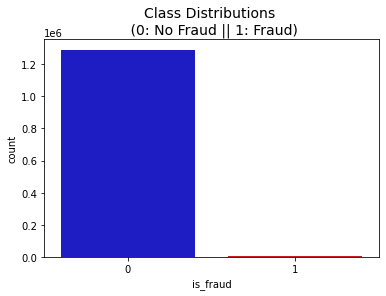

In [33]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('is_fraud', data=X_train, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

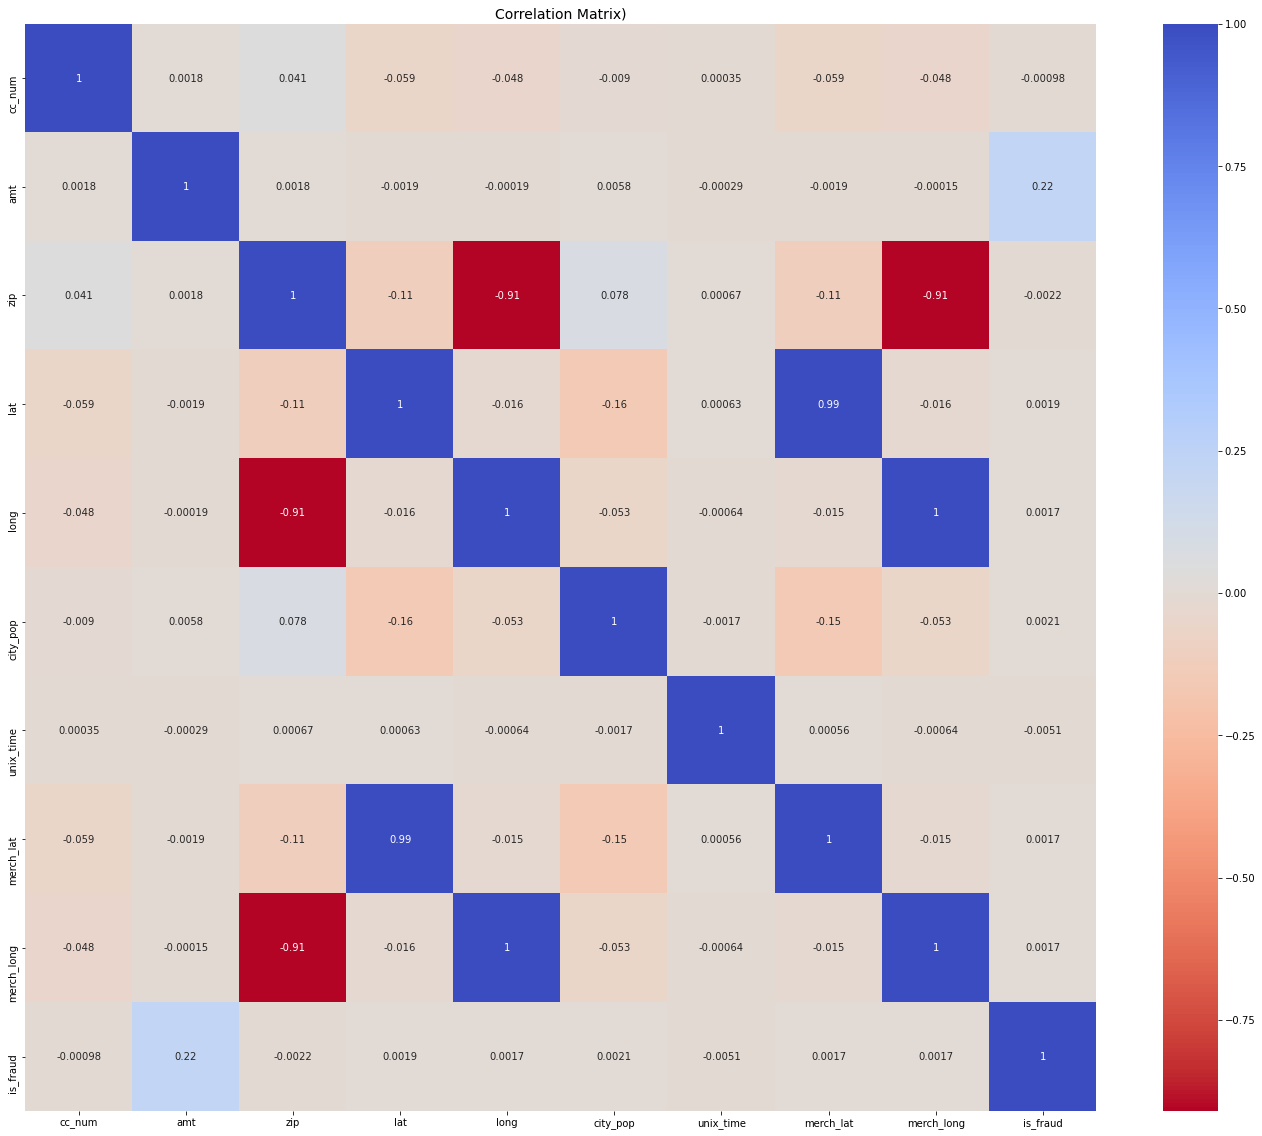

In [34]:
f, ax1 = plt.subplots(1, 1, figsize=(24,20))

sns.heatmap(X_train.corr(), cmap='coolwarm_r', annot_kws={'size':10},annot=True, ax=ax1)
ax1.set_title("Correlation Matrix)", fontsize=14)

plt.show()

In [35]:
print("Looking on categorical data and try to identify which can be transformed to numeric categorical")
# print("trans_date_trans_time", X_test['trans_date_trans_time'].nunique()) # too much, we need to modify it
print("merchant", X_test['merchant'].nunique())
print("category", X_test['category'].nunique())
print("gender", X_test['gender'].nunique())
print("city", X_test['city'].nunique())
print("state", X_test['state'].nunique())
print("job", X_test['job'].nunique())
print("dob", X_test['dob'].nunique())

X_train.gender = X_train.gender.astype('category').cat.codes
X_test.gender = X_test.gender.astype('category').cat.codes

X_train.job = X_train.job.astype('category').cat.codes
X_test.job = X_test.job.astype('category').cat.codes

X_train.category = X_train.category.astype('category').cat.codes
X_test.category = X_test.category.astype('category').cat.codes

X_train.merchant = X_train.merchant.astype('category').cat.codes
X_test.merchant = X_test.merchant.astype('category').cat.codes

X_train.merchant = X_train.merchant.astype('category').cat.codes
X_test.merchant = X_test.merchant.astype('category').cat.codes

X_train.dob = X_train.dob.astype('category').cat.codes
X_test.dob = X_test.dob.astype('category').cat.codes

Looking on categorical data and try to identify which can be transformed to numeric categorical
merchant 693
category 14
gender 2
city 849
state 50
job 478
dob 910


In [36]:
X_train = convert_cc_to_cc_type_and_drop(X_train)
X_test = convert_cc_to_cc_type_and_drop(X_test)

X_train.cc_type = X_train.cc_type.astype('category').cat.codes
X_test.cc_type = X_test.cc_type.astype('category').cat.codes

In [37]:
X_train = unite_state_city(X_train)
X_test = unite_state_city(X_test)

X_train.city = X_train.city.astype('category').cat.codes
X_test.city = X_test.city.astype('category').cat.codes

X_train.state = X_train.state.astype('category').cat.codes
X_test.state = X_test.state.astype('category').cat.codes

In [38]:
X_train.info()
print("-" * 100)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 17 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   merchant    1296675 non-null  int16  
 1   category    1296675 non-null  int8   
 2   amt         1296675 non-null  float64
 3   gender      1296675 non-null  int8   
 4   city        1296675 non-null  int16  
 5   state       1296675 non-null  int8   
 6   zip         1296675 non-null  int64  
 7   lat         1296675 non-null  float64
 8   long        1296675 non-null  float64
 9   city_pop    1296675 non-null  int64  
 10  job         1296675 non-null  int16  
 11  dob         1296675 non-null  int16  
 12  unix_time   1296675 non-null  int64  
 13  merch_lat   1296675 non-null  float64
 14  merch_long  1296675 non-null  float64
 15  is_fraud    1296675 non-null  int64  
 16  cc_type     1296675 non-null  int8   
dtypes: float64(5), int16(4), int64(4), int8(4)
memory usage: 103.9 MB

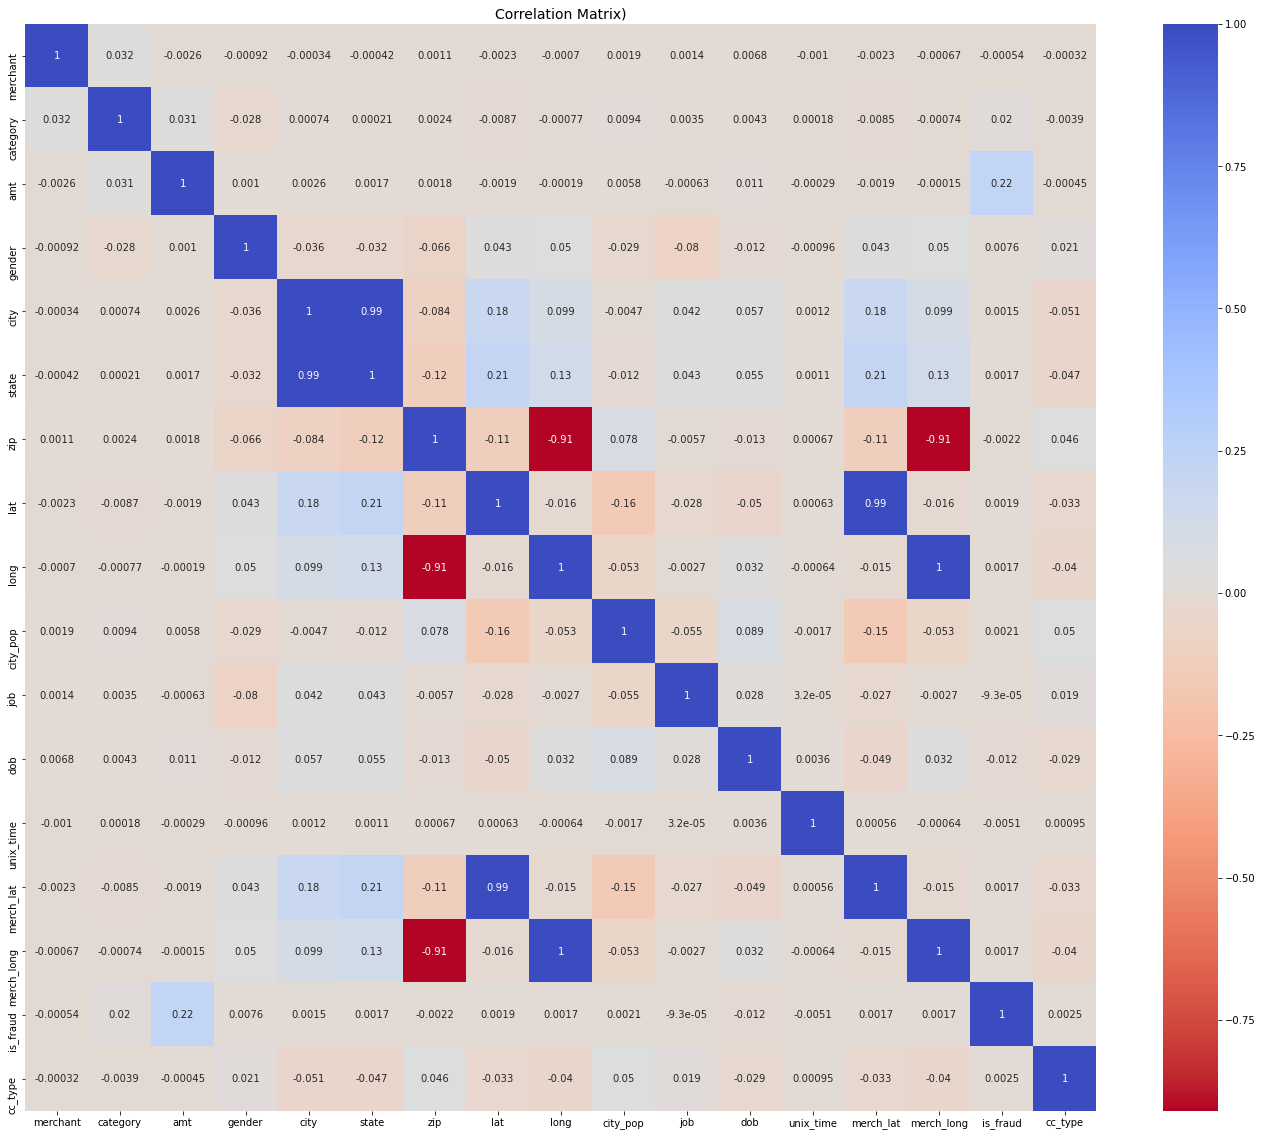

In [39]:
f, ax1 = plt.subplots(1, 1, figsize=(24,20))

sns.heatmap(X_train.corr(), cmap='coolwarm_r', annot_kws={'size':10},annot=True, ax=ax1)
ax1.set_title("Correlation Matrix)", fontsize=14)

plt.show()

In [40]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression

# del X_train['is_fraud']
scores = cross_validate(LogisticRegression(),
                        X_train, Y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

(0.6319641369406108, 0.21035321761104106)

In [42]:
scores = cross_validate(RandomForestClassifier(n_estimators=100,
                                               class_weight='balanced'),
                        X_train, Y_train, cv=10,
                        scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

# K-Nearest Neighbors is usually where the introduction class leaves off
# X_train, X_test, y_train, y_test = train_test_split(X, y)
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
nb = BernoulliNB()
nb.fit(X_train, Y_train)

print("KNN")
print(classification_report(knn.predict(X_test), y_test))
print("Naive Bayesian")
print(classification_report(nb.predict(X_test), y_test))

In [14]:
data = drop_columns(read_data("fraudTrain.csv"), ["Unnamed: 0"])
df = data
# data = convert_cc_to_cc_type_and_drop(data)
# data = convert_dob_to_age_and_drop(data)
# data = unite_state_city(data)

In [15]:
fraud = data[data['is_fraud']==1]
normal = data[data['is_fraud']==0]

In [18]:
data = convert_and_scale(data)

convert_cc_to_cc_type_and_drop finished
convert_dob_to_age_and_drop finished
unite_state_city finished
convert_unix_to_hour finished


In [19]:
data

,scaled_amount,trans_date_trans_time,merchant,category,first,last,gender,street,city,state,...,long,city_pop,job,trans_num,merch_lat,merch_long,is_fraud,cc_type,age_in_days,trans_hour
0,-0.578990,2019-01-01 00:00:18,514,8,Jennifer,Banks,0,561 Perry Cove,452,27,...,-81.1781,3495,370,0b242abb623afc578575680df30655b9,36.011293,-82.048315,0,6,11255,0.005000
1,0.812491,2019-01-01 00:00:44,241,4,Stephanie,Gill,0,43039 Riley Greens Suite 393,873,47,...,-118.2105,149,428,1f76529f8574734946361c461b024d99,49.159047,-118.186462,0,4,14804,0.012222
2,2.348483,2019-01-01 00:00:51,390,0,Edward,Sanchez,1,594 White Dale Suite 530,185,13,...,-112.2620,4154,307,a1a22d70485983eac12b5b88dad1cf95,43.150704,-112.154481,0,1,20801,0.014167
3,-0.034290,2019-01-01 00:01:16,360,2,Jeremy,White,1,9443 Cynthia Court Apt. 038,435,26,...,-112.1138,1939,328,6b849c168bdad6f867558c3793159a81,47.034331,-112.561071,0,3,18982,0.021111
4,-0.075657,2019-01-01 00:03:06,297,9,Tyler,Garcia,1,408 Bradley Rest,841,45,...,-79.4629,99,116,a41d7549acf90789359a9aa5346dcb46,38.674999,-78.632459,0,0,11967,0.051667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,-0.434889,2020-06-21 12:12:08,499,0,Erik,Patterson,1,162 Jessica Row Apt. 072,829,44,...,-112.4777,258,215,440b587732da4dc1a6395aba5fb41669,36.841266,-111.690765,0,1,21394,12.202222
1296671,0.056878,2020-06-21 12:12:19,2,1,Jeffrey,White,1,8617 Holmes Terrace Suite 651,318,20,...,-77.5101,100,360,278000d2e0d2277d1de2f890067dcc0a,38.906881,-78.246528,0,2,14803,12.205278
1296672,0.794802,2020-06-21 12:12:32,599,1,Christopher,Castaneda,1,1632 Cohen Drive Suite 639,515,32,...,-105.8189,899,308,483f52fe67fabef353d552c1e662974c,33.619513,-105.130529,0,8,19289,12.208889
1296673,0.372568,2020-06-21 12:13:36,509,1,Joseph,Murray,1,42933 Ryan Underpass,750,41,...,-102.5411,1126,485,d667cdcbadaaed3da3f4020e83591c83,42.788940,-103.241160,0,6,14552,12.226667


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

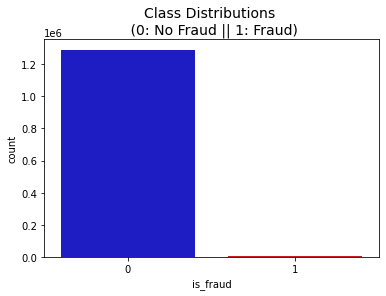

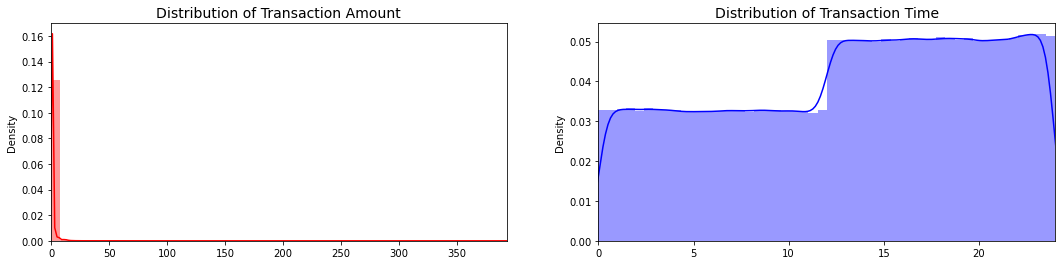

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = data['scaled_amount'].values
time_val = data['trans_hour'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

In [24]:
### create balanced data set ###

df = data.sample(frac=1) #shuffled data (entire set)

fraud_df = df.loc[df['is_fraud'] == 1]
non_fraud_df = df.loc[df['is_fraud'] == 0][:AMOUNT_OF_FRAUD]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

#new_df.head()
new_df

,scaled_amount,trans_date_trans_time,merchant,category,first,last,gender,street,city,state,...,long,city_pop,job,trans_num,merch_lat,merch_long,is_fraud,cc_type,age_in_days,trans_hour
81950,3.853586,2019-02-18 05:13:22,459,4,Adam,Kirk,1,40847 Stark Junctions,536,34,...,-74.4530,397,368,9dd863cfcf9e3f8aacabdef2ed966529,41.118125,-73.902983,1,8,31936,5.222778
125933,3.738332,2019-03-10 23:34:08,239,4,Tanya,Williams,0,566 Megan Well,540,34,...,-76.0196,1271,354,6779bec24a61cd0adedf50e0fe25da0f,44.253963,-75.228632,1,3,22123,23.568889
27781,0.522112,2019-01-17 02:19:58,239,4,Mackenzie,Smith,0,7178 Willis Drive,474,29,...,-96.5232,1745,155,afa0b6315b591ed6c1c51601c730686b,42.389859,-96.866445,0,7,16458,2.332778
1050381,-0.159341,2020-03-11 12:20:08,492,6,Kenneth,Robinson,1,269 Sanchez Rapids,499,31,...,-74.2239,124967,319,08195259496d449962dcf2d2fabf1f57,40.144150,-74.224090,0,7,14325,12.335556
106735,7.437338,2019-03-02 23:01:54,145,0,Mary,Diaz,0,9886 Anita Drive,918,50,...,-108.8964,1645,246,e29fe2c9dee909dc9013fbdaa8684e7b,42.468523,-109.687147,1,8,12066,23.031667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146299,3.208872,2019-03-20 01:49:25,472,4,Christopher,Raymond,1,766 Potter Well,589,34,...,-73.5112,4778,175,4d47bb30cc4c23622c7cecae15a1f243,44.306634,-73.995580,1,1,23655,1.823611
1025758,0.041638,2020-03-01 10:20:20,415,4,Adam,Santos,1,725 Jo Trace Apt. 102,63,4,...,-118.2322,172817,12,1fdf98154b87af9c49e9b97e58f211e9,34.902727,-118.082738,0,8,13729,10.338889
1036753,2.808681,2020-03-05 22:16:48,506,6,Christie,Williamson,0,519 Jerry Views,165,12,...,-95.3509,2036,175,95ffbfac1a63e60ad28dc9033152ab21,41.046356,-96.051987,1,7,17730,22.280000
1292954,9.980269,2020-06-19 23:59:27,383,8,Jessica,Garcia,0,13108 Jennifer Passage,254,16,...,-99.5540,320,193,2c89bcd47f8698e45a9018696c6ff945,37.930150,-99.491890,1,7,21608,23.990833


Distribution of the fraud in the subsample dataset
1    0.5
0    0.5
Name: is_fraud, dtype: float64


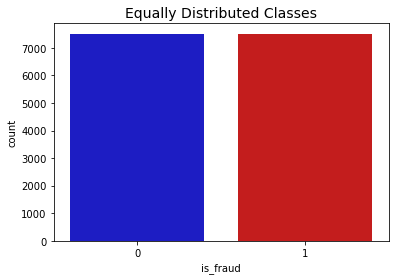

In [26]:
print('Distribution of the fraud in the subsample dataset')
print(new_df['is_fraud'].value_counts()/len(new_df))



sns.countplot('is_fraud', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [74]:
df.shape
new_df.shape

(4290, 9)

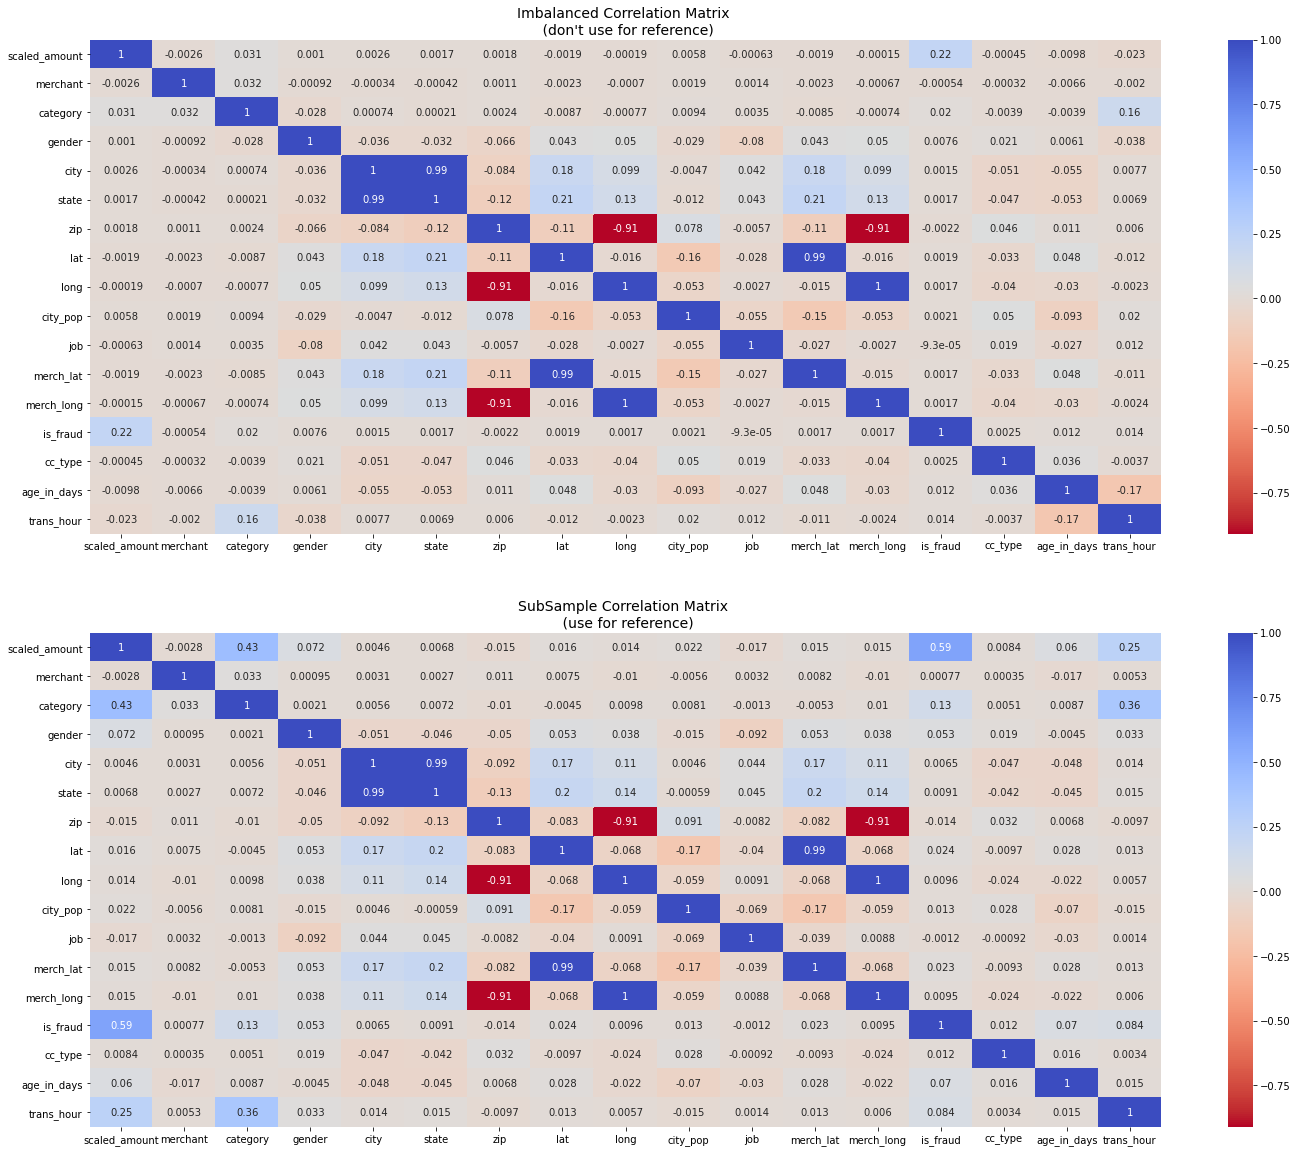

In [27]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':10},annot=True, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r',  annot_kws={'size':10},annot=True, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [28]:
columns_to_drop = ['gender','city','state','cc_type','age_in_days','merchant','amt','unix_time','trans_date_trans_time','first','last','street','trans_num','job','age','city_pop','zip','lat','long', 'merch_lat','merch_long']

In [32]:
new_df = drop_columns(new_df,columns_to_drop)
new_df

,scaled_amount,category,is_fraud,trans_hour
81950,3.853586,4,1,5.222778
125933,3.738332,4,1,23.568889
27781,0.522112,4,0,2.332778
1050381,-0.159341,6,0,12.335556
106735,7.437338,0,1,23.031667
...,...,...,...,...
146299,3.208872,4,1,1.823611
1025758,0.041638,4,0,10.338889
1036753,2.808681,6,1,22.280000
1292954,9.980269,8,1,23.990833


In [33]:
classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier()
}

In [34]:
new_df

,scaled_amount,category,is_fraud,trans_hour
81950,3.853586,4,1,5.222778
125933,3.738332,4,1,23.568889
27781,0.522112,4,0,2.332778
1050381,-0.159341,6,0,12.335556
106735,7.437338,0,1,23.031667
...,...,...,...,...
146299,3.208872,4,1,1.823611
1025758,0.041638,4,0,10.338889
1036753,2.808681,6,1,22.280000
1292954,9.980269,8,1,23.990833


In [35]:
label = new_df['is_fraud'].values
converted_df_no_label = new_df.drop('is_fraud',axis=1).values
converted_df_no_label

array([[ 3.85358552,  4.        ,  5.22277778],
       [ 3.73833175,  4.        , 23.56888889],
       [ 0.52211185,  4.        ,  2.33277778],
       ...,
       [ 2.80868145,  6.        , 22.28      ],
       [ 9.98026942,  8.        , 23.99083333],
       [-0.37392843,  5.        , 23.165     ]])

In [37]:
for key, classifier in classifiers.items():
    classifier.fit(converted_df_no_label, label)
    training_score = cross_val_score(classifier, converted_df_no_label, label, cv=5, scoring="f1")
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 84.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 96.0 % accuracy score
Classifiers:  SVC Has a training score of 89.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 97.0 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 97.0 % accuracy score


In [52]:
# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(converted_df_no_label, label)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

print("log reg: best params",grid_log_reg.best_params_)
knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(converted_df_no_label, label)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_
print("grid_knears: best params",grid_knears.best_params_)

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1]} #,  'gamma': [1e-3, 1e-4]}
#               'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(converted_df_no_label, label)

# SVC best estimator
svc = grid_svc.best_estimator_
print("svc: best params",grid_svc.best_params_)

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(converted_df_no_label, label)

# tree best estimator
tree_clf = grid_tree.best_estimator_
print("tree: best params",grid_tree.best_params_)

# RandomForest
forest_params = {"criterion": ["gini", "entropy"]}   #"max_depth": [list(range(2,4,1)), 
             # "min_samples_leaf": list(range(5,7,1))}
grid_forest = GridSearchCV(RandomForestClassifier(), forest_params)
grid_forest.fit(converted_df_no_label, label)

# tree best estimator
forest_clf = grid_forest.best_estimator_
print("forest: best params",grid_forest.best_params_)


log reg: best params {'C': 0.001, 'penalty': 'l2'}
grid_knears: best params {'algorithm': 'auto', 'n_neighbors': 4}
svc: best params {'C': 1}
tree: best params {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 5}
forest: best params {'criterion': 'gini'}


In [39]:
### f1 score ###
log_reg_score = cross_val_score(log_reg, converted_df_no_label, label, cv=5, scoring="f1")
print('Logistic Regression Cross Validation f1 Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')

knears_score = cross_val_score(knears_neighbors, converted_df_no_label, label, cv=5, scoring="f1")
print('Knears Neighbors Cross Validation f1 Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, converted_df_no_label, label, cv=5, scoring="f1")
print('Support Vector Classifier Cross Validation f1 Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, converted_df_no_label, label, cv=5, scoring="f1")
print('DecisionTree Classifier Cross Validation f1 Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

forest_score = cross_val_score(forest_clf, converted_df_no_label, label, cv=5,scoring="f1")
print('RandomForest Classifier Cross Validation f1 Score', round(forest_score.mean() * 100, 2).astype(str) + '%')



Logistic Regression Cross Validation f1 Score:  84.02%
Knears Neighbors Cross Validation f1 Score 96.29%
Support Vector Classifier Cross Validation f1 Score 88.61%
DecisionTree Classifier Cross Validation f1 Score 88.18%
RandomForest Classifier Cross Validation f1 Score 97.3%


In [46]:
test_df =  drop_columns(read_data("fraudTest.csv"), ["Unnamed: 0"])

In [47]:
test_df.describe()
y_test = test_df['is_fraud']

In [48]:
test_df = convert_and_scale(test_df)

convert_cc_to_cc_type_and_drop finished
convert_dob_to_age_and_drop finished
unite_state_city finished
convert_unix_to_hour finished


In [49]:
test_df= drop_columns(test_df,columns_to_drop)
test_df

,scaled_amount,category,is_fraud,trans_hour
0,-0.605478,10,0,12.240278
1,-0.237803,10,0,12.242500
2,-0.081902,5,0,12.248056
3,0.173889,9,0,12.254167
4,-0.600981,13,0,12.254722
...,...,...,...,...
555714,-0.047969,5,0,23.985278
555715,0.879667,7,0,23.985833
555716,0.539520,7,0,23.987500
555717,-0.535568,13,0,23.990000


In [50]:
test_df = drop_columns(test_df,['is_fraud'])

forest_clf.fit(converted_df_no_label, label)
predictions = forest_clf.predict(test_df)
print(classification_report(y_test, predictions, target_names=['Normal','Is Fraud']))

              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98    553574
    Is Fraud       0.11      0.97      0.20      2145

    accuracy                           0.97    555719
   macro avg       0.55      0.97      0.59    555719
weighted avg       1.00      0.97      0.98    555719



[[536507  17067]
 [    58   2087]]
accuracy is 0.9694449892841526


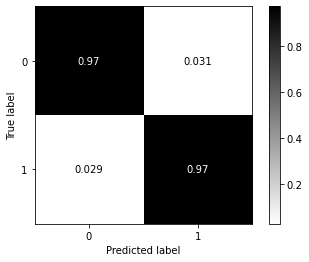

In [51]:
print(confusion_matrix(y_test, predictions))
print(f"accuracy is {model.score(test_df, y_test)}")
plot_confusion_matrix(model, test_df, y_test, cmap='gray_r',normalize='true')

In [ ]:
pd.concat([fraud.amt.describe(), normal.amt.describe()], keys=["fraud_amt", "non_fraud_amt"], axis=1)

In [ ]:
### plot all the features via seaborn ### 
percent = 0.01
columns_to_drop = ['trans_date_trans_time','state','zip','lat','long','first','last','street','trans_num','unix_time']
partial_data = get_partial_data(data,percent)
partial_data = drop_columns(partial_data,columns_to_drop)
partial_data

In [ ]:
sns.pairplot(partial_data, hue='is_fraud') 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


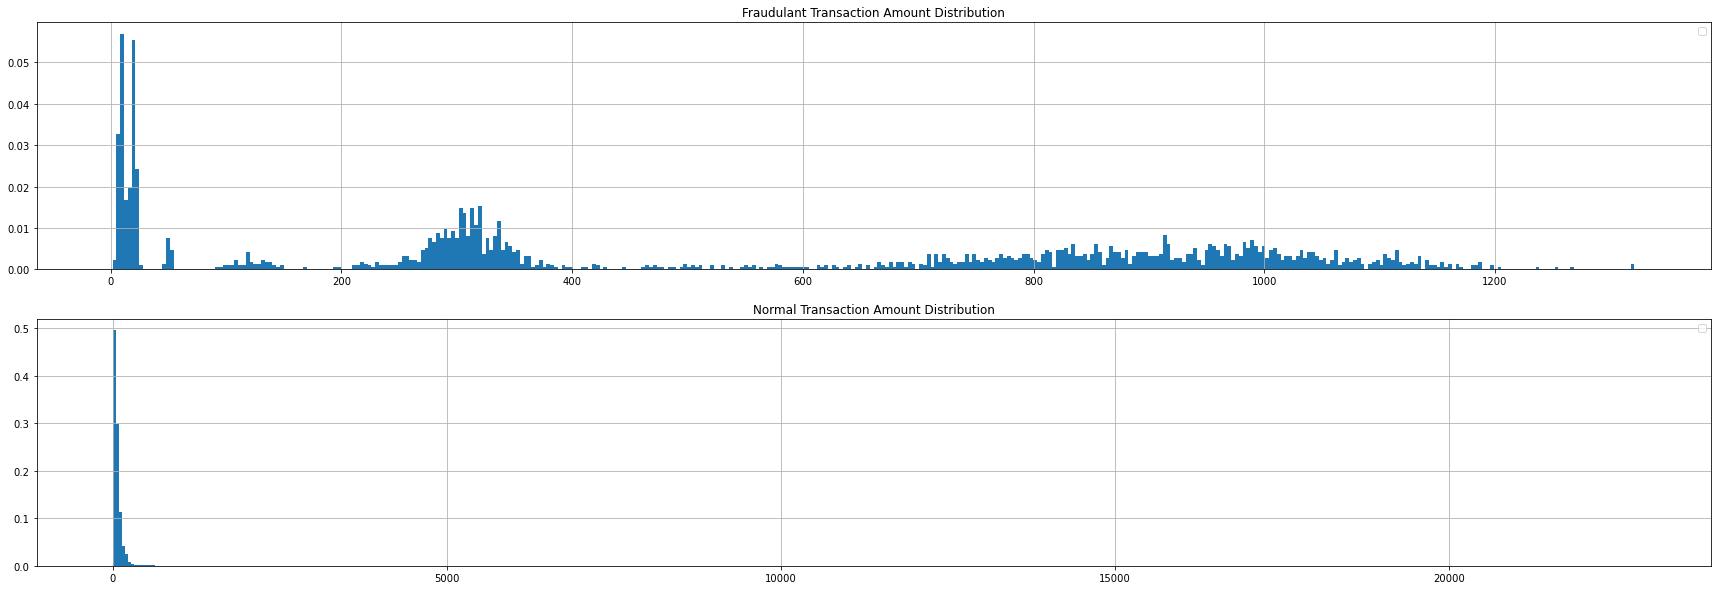

In [77]:
##### atm #####
plt.figure(figsize=(30, 10))

print()
plt.subplot(2, 1, 1)
subfraud = fraud #[fraud.amt<500]
subfraud.amt.hist(bins=400,weights=np.ones(len(subfraud.amt)) / len(subfraud.amt))
plt.title("Fraudulant Transaction Amount Distribution")
plt.legend()
# plt.xlim([-10,400])
# plt.ylim([0,0.1])

plt.subplot(2, 1, 2)
subnormal = normal #[normal.amt<400]
subnormal.amt.hist(bins=500, weights=np.ones(len(subnormal.amt)) / len(subnormal.amt))
plt.title("Normal Transaction Amount Distribution")
plt.legend()
# plt.xlim([-10,400])
# plt.ylim([0,0.1])

## Conclusion
We can see that transaction's amount is a good feature for fraud transaction recognition

<Figure size 504x360 with 0 Axes>

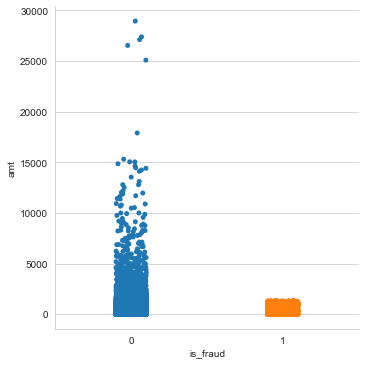

In [132]:
### atm via seaborn ###
plt.figure(figsize=(7,5))
sns.set_style('whitegrid')
sns.catplot(x='is_fraud',y='amt', hue='is_fraud',data=data)

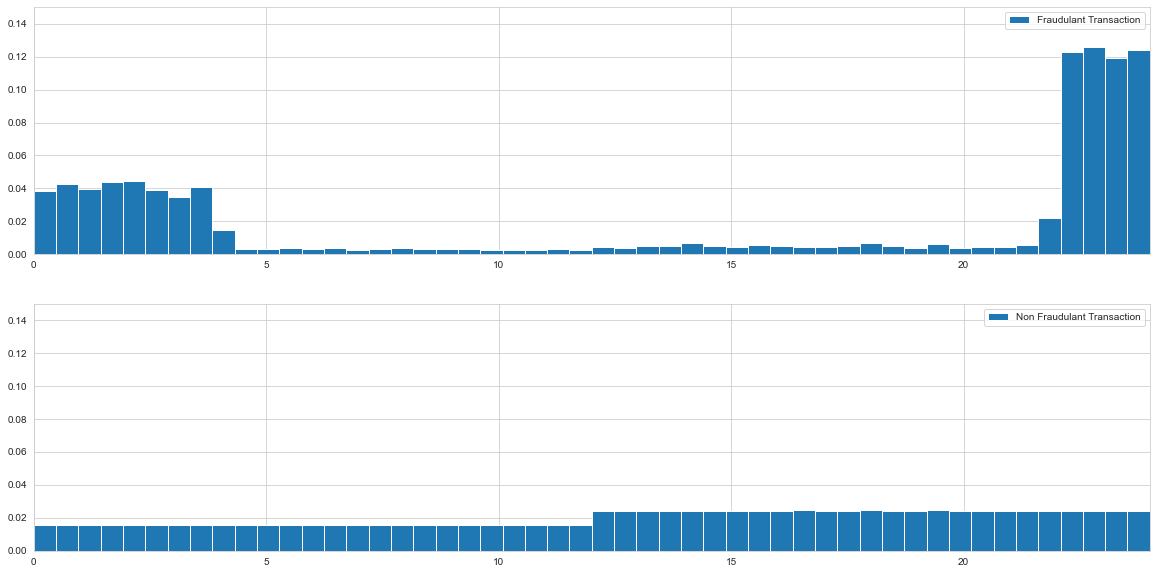

In [133]:
##### time #####

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
fraud_24time = fraud.copy()
fraud_24time.unix_time = fraud_24time.unix_time % 86400 #(86400s per 24h)
fraud_24time.unix_time /= (86400/24)
fraud_24time.unix_time.hist(bins=50,label="Fraudulant Transaction",weights=np.ones(len(fraud_24time)) / len(fraud_24time))
plt.xlim([0,24])
plt.ylim([0,0.15])
plt.xlabel("")
plt.legend()

plt.subplot(2, 1, 2)
normal_24time = normal.copy()
normal_24time.unix_time  = normal_24time.unix_time  % 86400 #(86400s per 24h)
normal_24time.unix_time  /= (86400/24)
normal_24time.unix_time .hist(bins=50,label="Non Fraudulant Transaction",weights=np.ones(len(normal_24time)) / len(normal_24time))
plt.xlim([0,24])
plt.ylim([0,0.15])
plt.legend()

## Conclusion
We can see that transaction's time is a good feature for fraud transaction recognition

In [ ]:
##### category #####
category_df = pd.concat([fraud.category.value_counts()/len(fraud.index), normal.category.value_counts()/len(normal.index)], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))

category_df.plot(kind='bar',ax=axes)

## Conclusion
We can see that transaction category is a good feature for fraud recognition

In [ ]:
##### city #####
np.set_printoptions(suppress=True)
dropped = data.drop_duplicates(["city"], inplace=False)
total_pupulation = dropped.city_pop.sum()

dropped.city_pop = dropped.city_pop / total_pupulation
dropped.index  = dropped.city
dropped

city_df = pd.concat(
    [
        fraud.city.value_counts()/len(fraud.index), 
        normal.city.value_counts()/len(normal.index),
        # dropped.city_pop
    ], 
    # keys=["fraud", "normal", "normalized_pop"], 
    keys=["fraud", "normal"], 
    axis=1)

city_df

# /total_pupulation
# dropped.city_pop.value_counts()

# grouped = data.groupby('city')
# data.city.unique()
# data.loc['city', data.city.unique()]

# data.city_pop.sum()
fig, axes = plt.subplots(1, 1, figsize=(20,10))
city_df.plot(kind='bar',ax=axes)


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("50 cities with high fraud distribution")
city_df[:50].plot(kind='bar',ax=axes)


In [ ]:
city_df.index[0]
city_count = {}
for i in range(50):
    fraud_city = fraud[fraud['city']==city_df.index[i]]
    lat_unique = fraud_city.lat.nunique()
    long_unique = fraud_city.long.nunique()
    city_count[city_df.index[i]]= lat_unique > 1  or long_unique > 1

city_count

## Conclusion
We can see that location of card holder is not a good feature to recognize fraud.

In [ ]:
fig, axes = plt.subplots(5, 4, figsize=(20, 50))

for i, ax in enumerate(axes.ravel()):
    fraud_city =  fraud[fraud['city']==city_df.index[i]]
    normal_city =  normal[normal['city']==city_df.index[i]]
    ax.scatter(normal_city.merch_lat, normal_city.merch_long, label="Normal", alpha=1,color='green')
    ax.scatter(fraud_city.merch_lat, fraud_city.merch_long,label='Fraud', alpha=1, color='red',s=400)
    ax.legend()
    feature_name = city_df.index[i]
    ax.set_title("{}".format(feature_name), fontdict=title_font)
    ax.grid()
    
plt.tight_layout()


## Conclusion
Above we plot the locations of merchant in the cities with the highest fraud density. As we can see, there is no pattern and merchan location is not a good feature to recognize the fraud. 

In [ ]:
### population ###

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
fraud.city_pop.hist(bins=50,label="Fraudulant City Population",density=True,color='red')
plt.legend()

plt.subplot(2, 1, 2)
normal.city_pop.hist(bins=50,label="Non Fraudulant City Population",density=True,color='green')
plt.legend()

## Conclusion
We can see that city population is not a good feature to distinguish between a fraud and normal transaction. 

In [ ]:
### zip code ### 
fraud.zip
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
fraud.zip.hist(bins=50,label="Fraudulant Zip",density=True)
plt.legend()

plt.subplot(2, 1, 2)
normal.zip.hist(bins=50,label="Non Fraudulant Transaction",density=True)
plt.legend()

In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders import TargetEncoder
orig_zip = data['zip']
label = data['is_fraud']
data_no_label = drop_columns(data,'is_fraud')
te = TargetEncoder(cols='zip',return_df=True, drop_invariant = True).fit(data_no_label,label)
transformed = te.transform(data_no_label)
data['zip'] = transformed['zip'] # replace zip with fraud probability per zip

In [ ]:
zip_db = pd.concat([orig_zip,transformed['zip'],label], axis=1, keys=['orig_zip', 'fraud_probability','label'])
zip_faud_prob = pd.DataFrame(zip_db.groupby('orig_zip')['fraud_probability'].mean())
zip_faud_prob.sort_values(by='fraud_probability',ascending = False, inplace = True)

fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("Fraud probability per zip-code")
zip_faud_prob.plot(kind='bar',ax=axes,logy=True,rot = 45)

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("Zipcodes with the highest Fraud probability")
zip_faud_prob[:50].plot(kind='bar',ax=axes,rot = 45)

## Conclusion
We can see that there are zipcodes with high probability of fraud, therefore zipcode is a good feature to distinguish between a fraud and normal transaction. 

In [ ]:
##### state #####
state_df = pd.concat(
    [
        fraud.state.value_counts()/len(fraud.index), 
        normal.state.value_counts()/len(normal.index),
    ], 
    keys=["fraud", "normal"], 
    axis=1)


In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("Distribution of card holders per state")
state_df.plot(kind='bar',ax=axes)

In [ ]:
##### gender #####
gender_df = pd.concat(
    [
        fraud.gender.value_counts()/len(fraud.index), 
        normal.gender.value_counts()/len(normal.index),
    ], 
    keys=["fraud", "normal"], 
    axis=1)

fig, axes = plt.subplots(1, 1, figsize=(20,10))

gender_df.plot(kind='bar',ax=axes)

## Conclusion
As we can see, gender is not significally vary between fraud and normal card holders.

In [ ]:
##### job #####
job_db = pd.concat(
    [
        fraud.job.value_counts()/len(fraud.index), 
        normal.job.value_counts()/len(normal.index),
    ], 
    keys=["fraud", "normal"], 
    axis=1)

fig, axes = plt.subplots(1, 1, figsize=(20,10))

job_db.plot(kind='bar',ax=axes)

## Conclusion
We can see that job is a good feature for fraud recognition

In [ ]:
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2-lat1)
    delta_lambda = np.radians(lon2-lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)))
    return np.round(res, 2)

def calculate_holder_merch_distance(df):
    _df = df.copy()
    dist_list = []
    
    for index, row in df.iterrows():
        dist = haversine_distance(row['lat'],row['long'],row['merch_lat'],row['merch_long'])
        dist_list.append(dist)
    _df['holder_merch_dist'] = dist_list
    return _df

In [ ]:
### location ### 

fraud  = calculate_holder_merch_distance(fraud)
normal = calculate_holder_merch_distance(normal)

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
fraud.holder_merch_dist.hist(bins=50,label="Fraudulant Distance",density=True)
plt.legend()

plt.subplot(2, 1, 2)
normal.holder_merch_dist.hist(bins=50,label="Non Fraudulant Distance",density=True)
plt.legend()


## Conclusion
We can see that distance between card holder location and merchant location is not a good feature for fraud recognition

In [ ]:
##### card type #####
card_type_df = pd.concat([fraud.cc_type.value_counts()/len(fraud.index), normal.cc_type.value_counts()/len(normal.index)], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))
card_type_df.plot(kind='bar',ax=axes)

In [ ]:
### avrg amount per card type ### 
fraud_avrg_card_amt = fraud.groupby('cc_type')['amt'].mean()
normal_avrg_card_amt = normal.groupby('cc_type')['amt'].mean()
amt_per_category = pd.concat([fraud_avrg_card_amt, normal_avrg_card_amt], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))
amt_per_category.plot(kind='bar',ax=axes)

## Conclusion
We can see that card type is not a good feature for fraud recognition

In [ ]:
##### merchant #####
merch_type_df = pd.concat([fraud.merchant.value_counts()/len(fraud.index), normal.merchant.value_counts()//len(normal.index)], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("Merchant")
merch_type_df.plot(kind='bar',ax=axes)

In [ ]:
num = 20
fig, axes = plt.subplots(1, 1, figsize=(20,10))
axes.set_title("{} {} {}".format("Top", num, "of fraud merchant"))
merch_type_df[:num].plot(kind='bar',ax=axes)

## Conclusion 
We can see that there are merchants that has only fraud transactions. 
## TBD 
What we can conclude from this? Should we take into account specific merchant when we train the model? It's heavy feature - 693 unique categories. We have to OneHot it, means +693 columns 

In [ ]:
### dob ###
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
fraud.age_in_days.hist(bins=100,label="Fraudulant Age",density=True)
plt.legend()

plt.subplot(2, 1, 2)
normal.age_in_days.hist(bins=100,label="Non Fraudulant Age",density=True)
plt.legend()



## Conclusion
We can see that age is not a good feature for fraud recognition

In [ ]:
### average amt per category ### 
fraud_avrg_amt = fraud.groupby('category')['amt'].mean()
normal_avrg_amt = normal.groupby('category')['amt'].mean()
amt_per_category = pd.concat([fraud_avrg_amt, normal_avrg_amt], keys=["fraud_category", "non_fraud_category"], axis=1)
fig, axes = plt.subplots(1, 1, figsize=(20,10))
amt_per_category.plot(kind='bar',ax=axes)

## Conclusion
We can see that there is significant difference between average amount of transactions made in each category between fraud and normal card holder. Also we can see that the most fraud transaction are made in the Internet.

In [ ]:
plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features',y=1,size=16)
sns.heatmap(data.corr(),square = True,  vmax=0.8)

In [ ]:
plt.figure(figsize=(30, 10))

print()
plt.subplot(2, 1, 1)
subfraud = fraud[fraud.amt<500]
subfraud.amt.hist(bins=400,weights=np.ones(len(subfraud.amt)) / len(subfraud.amt))
plt.title("Fraudulant Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

plt.subplot(2, 1, 2)
subnormal = normal[normal.amt<400]
subnormal.amt.hist(bins=500, weights=np.ones(len(subnormal.amt)) / len(subnormal.amt))
plt.title("Normal Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

In [ ]:
df_test = read_test_data()
df_test = convert_to_categorical_trans_date_and_drop(df_test)
# get_categorical_features(df_test).columns

df_test.amt.describe()

In [ ]:
fig, axes = plt.subplots(11, 1, figsize=(20, 70))
continuous_features = get_continuous_features(df_test)

for i, ax in enumerate(axes.ravel()):
    feature_name = continuous_features.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    y = continuous_features[feature_name].value_counts().sort_index()
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
    ax.set_ylabel("Counts", fontdict=labels_font)
    ax.plot(y)
    ax.grid()
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(4, 3, figsize=(20, 70))
x = df_test.is_fraud

for i, ax in enumerate(axes.ravel()):
    X_col = continuous_features.iloc[:, i]
#     ax.set_xlim(0, 1)
    ax.set_xlim(right=1)
    if X_col.nunique() > 10:
        ax.set_xlim(X_col.quantile(q=.0001), X_col.quantile(q=.9999))
        
    ax.scatter(x, X_col, alpha=.5)

    feature_name = continuous_features.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
#     ax.set_ylabel("Price ($)", fontdict=labels_font)
    ax.grid()
    
plt.tight_layout()

In [ ]:
categorical_features = get_categorical_features(df_test)


fig, axes = plt.subplots(3, 3, figsize=(30,60))
for i, ax in enumerate(axes.ravel()):
    if(i >= len(categorical_features.columns)):
        break
    categorical_features.iloc[:,i].value_counts().plot(kind='bar',ax=ax,rot=45)
    ax.set_title(categorical_features.columns[i])

## Task 2 Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset

In [ ]:
# pay attention: train data contains 1.300.000 samples
percent = 0.2 # 20%
partial_data = get_partial_data(data,percent)
print ("data size: {}\npercent: {:.2f}\npartial_data size {}".format(len(data.index),percent,len(partial_data.index)))
partial_data

In [ ]:
colums_to_drop = ['cc_num','gender','first','last','street','trans_num','merch_lat','merch_long','dob','lat','long','city_pop','merchant','state','trans_date_trans_time','unix_time']
partial_data= drop_columns(partial_data,colums_to_drop)
partial_data

In [ ]:
categorical = partial_data.dtypes == object
ohe = ColumnTransformer([('encoder', OneHotEncoder(), categorical)], remainder='passthrough')
transformed = pd.DataFrame.sparse.from_spmatrix(ohe.fit_transform(partial_data),columns=ohe.get_feature_names()) #TBD fix names of columns to human-readable
transformed

## Task 3 Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

## Task 4 Any model
Use any classification model we discussed (trees, forests, boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate

## Task 5 Feature Selections
Identify features that are important for your best model. Which features are most influential,and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

## Task 6 An explainable model
Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model withfew enough coefficients that you can reasonable look at all of them, or a tree with a smallnumber of leafs etc.